# we will implement chapter 2 data embeddings here

#### Below diagram is high level steps on what all things are involved in the embeddings process.

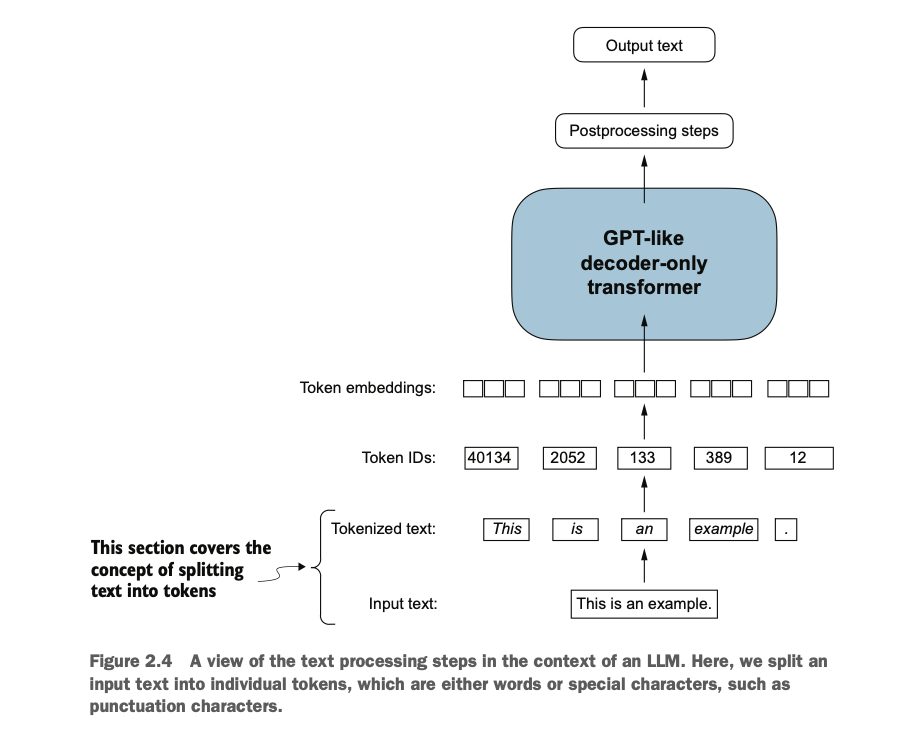

#### step 1 : loading the file to index

In [4]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)
    
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


## The goal is to tokenize and embed this text for the LLM.
#### step 2 : There are predefined tokenizers and embedding models available but we will build our own from scratch for better initial understanding. (author)

In [5]:
import re  # re library is for regular expressions in python

text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)

# Strip whitespace from each item and then filter out any empty strings.
result = [item for item in result if item.strip()]

print(result)   # ['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?'] - this is our `tokenized text`

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


#### step 3 : now tokenize text file raw_text the virdict.txt using the same splitter

In [6]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)  # our custom splitter
preprocessed = [item.strip() for item in preprocessed if item.strip()]  # strip whitespace and filter out empty strings
print(preprocessed[:30])  # display the first 30 tokens
print("Total no of tokens", len(preprocessed))  # display the total number of tokens

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']
Total no of tokens 4690


#### step 4 :  converting tokens into IDs
create your vocabulary from the tokenized text and assign a unique ID to each text token you have generated above.(section 2.3 in the book)
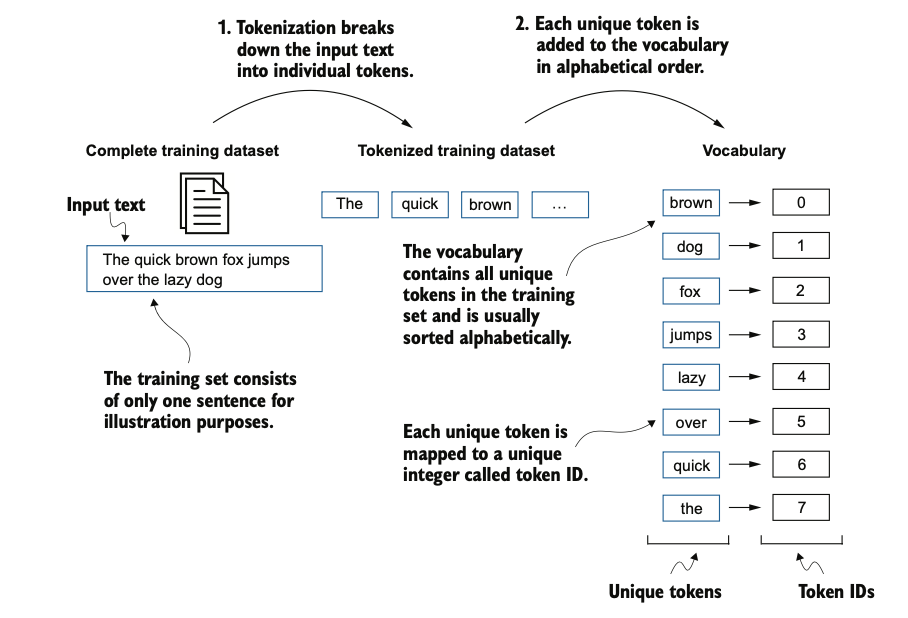

In [7]:
all_words = sorted(set(preprocessed)) # set() removes duplicates, sorted() sorts them
vocab_size = len(all_words) # size of the vocabulary
print(vocab_size)

vocab = {}
for integer, token in enumerate(all_words):
    vocab[token] = integer
# vocab = {token:integer for integer,token in enumerate(all_words)}  #conside code of above version

for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

1130
('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


#### step 5 : putting all together
The `encode` function turns text into token IDs
The `decode` function turns token IDs back into text

In [8]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
                                
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [10]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

print(tokenizer.decode(ids))

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]
" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


#### step 6 :  now, what if we encounter new word which is not in our vocabulary?
Lets introduce a special token `<unk>` for unknown words. Also <|endoftext|> for end of text.

In [11]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

Let's try to tokenize text with the modified tokenizer:

In [12]:
# We add two special tokens: <|endoftext|> and <|unk|> in our vocabulary
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}


In [13]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [15]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [16]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

#### Step 7 :  Byte Pair Encoding (BPE)
The BPE tokenizer was used to train LLMs such as GPT-2, GPT-3, and the original model used in ChatGPT.


In [ ]:
%pip install tiktoken==0.7.0

In [21]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.7.0


In [22]:
tokenizer = tiktoken.get_encoding("gpt2")
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print("encoded ids", integers)

strings = tokenizer.decode(integers)
print("decoded string",strings)

encoded ids [15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
decoded string Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


BPE tokenizer encodes and decodes unknown words, such as someunknownPlace, correctly. 
The BPE tokenizer can handle any unknown word. How does it achieve this without using <|unk|> tokens?
The algorithm underlying BPE breaks down words that aren’t in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words. So, thanks to the BPE algorithm, if the tokenizer encounters an unfamiliar word during tokenization, it can represent it as a sequence of subword tokens or characters.
For example, the word "hello" might be broken down into the tokens "he", "ll", and "o". This way, even if "hello" is not in the vocabulary, the tokenizer can still represent it.

The ability to break down unknown words into individual characters ensures that
the tokenizer and, consequently, the LLM that is trained with it can process any text,
even if it contains words that were not present in its training data.

### How BPE works internally? (interesting read)
BPE starts with adding all individual single characters to its vocabulary (“a,” “b,” etc.). In the next stage, it merges character combinations that frequently occur together into subwords. For example, “d” and “e” may be merged into the subword “de,” which is common in many English words like “define,” “depend,” “made,” and “hidden.” The merges are determined by a frequency cutoff.

# Data Sampling with the sliding window approach
## what is sliding windows means?
- For training samples, instead of using the entire text sequence at once, you create multiple smaller, overlapping samples by "sliding" a window of fixed size across your data. 
- Let's say you have tokenized text: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] and you want to create training samples with a window size of 4: then you do below 
    - Input: [1, 2, 3, 4] -> Target: 5
    - Input: [2, 3, 4, 5] -> Target: 6
    - Input: [3, 4, 5, 6] -> Target: 7
    - Input: [4, 5, 6, 7] -> Target: 8
    - Input: [5, 6, 7, 8] -> Target: 9
    - Input: [6, 7, 8, 9] -> Target: 10

In [23]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

enc_sample = enc_text[50:]

context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

5145
x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]
[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [24]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


in above arrow, everything left of the arrow (---->) refers to the input an LLM would receive, and the token ID on the right side of the arrow represents the target token ID that the LLM is supposed to predict.

## sliding window sampling with the BPE tokenizer using pytorch dataset and dataloader
Now we need two tensors :
  - input tensor containing the text(IDS) that LLM sees
  - target tensor containing the text(IDS) that LLM is supposed to predict 
- 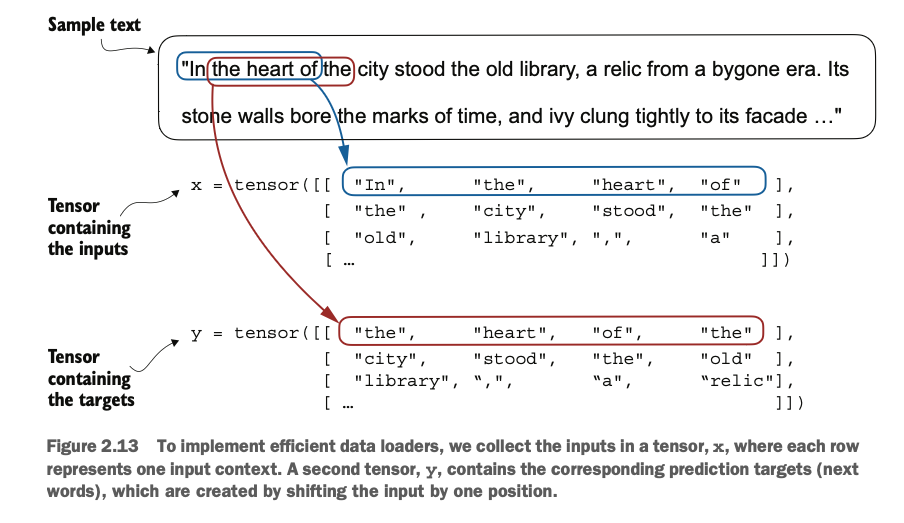

In [25]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.4.0


In [37]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):  # extending Dataset class
    def __init__(self, txt, tokenizer, max_length, stride):  # max_length is the window size
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
    




In [38]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4:

In [39]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [40]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


## Q. if in above code we kept stride= 1 it will overfit the entire text, why??
Overfit is the phenomenon where a model learns the training data too well, including its noise and outliers, leading to poor generalization to new, unseen data. In the context of using a stride of 1 in a sliding window approach for training a language model, here's why it can lead to overfitting:
-  Highly Redundant Samples: With a stride of 1, each training sample overlaps significantly with the previous one. For example, if your context size is 4, the samples would be:
    - Input: [1, 2, 3, 4] -> Target: 5
    - Input: [2, 3, 4, 5] -> Target: 6
    - Input: [3, 4, 5, 6] -> Target: 7
    - and so on...
  
   Each new sample shares most of its tokens with the previous sample. This high redundancy means the model sees very similar contexts repeatedly, which can lead it to memorize specific sequences rather than learning general language patterns.

In [53]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False) # we set stride=max_length to avoid overlapping samples to avoud the overfitting

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


# creating token embeddings
- The `last step in preparing the input text for LLM training is to convert the token IDs
into embedding vectors`.
- After converting text into token IDs, `token embeddings` play a crucial role in representing these token IDs as dense, continuous vectors in a high-dimensional space.
- This transformation is essential for enabling neural networks, particularly in NLP models like LLMs, to process and understand the relationships between tokens.
- This representation allows models to understand the semantic meaning of words and their relationships.
- Usually, these embedding layers are part of the LLM itself and are updated (trained) during model training
- 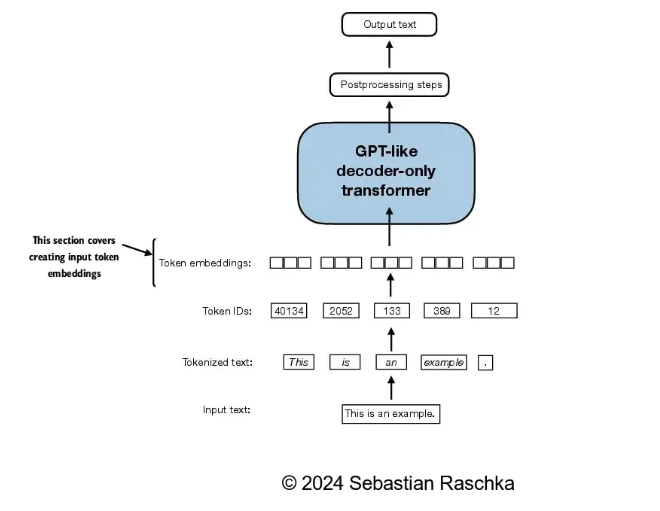

## why do we need token embeddings after converting text into token IDs?
- Text (words/tokens) is categorical — neural nets need numbers.
- An embedding maps each token ID to a fixed-length continuous vector.
- The embedding layer stores those vectors in a matrix and looks them up by token ID.

## The embedding layer: what it is ?
- Internally it's a matrix of shape (vocab_size, embedding_dim).
  - `vocab_size` = number of distinct token IDs (e.g. 50,257 for the BPE tokenizer).
  - `embedding_dim` (aka output_dim) = how many numbers represent a token (e.g. 256).
In PyTorch: `torch.nn.Embedding(vocab_size, embedding_dim)` — which creates that matrix and makes it trainable.

In [93]:
# For the sake of simplicity, suppose we have a small vocabulary of only 6 words and we want to create embeddings of size 3

vocab_size = 6
output_dim = 3 # embedding dimension - how many numbers represent a token

input_ids = torch.tensor([2, 3, 5, 1])

torch.manual_seed(123) # manual seed - Its important to set the manual seed before creating the embedding layer to ensure reproducibility of the random weights initialization.
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)


embeddings = embedding_layer(input_ids)
print(embeddings) # This returns a 4 x 3 matrix because we have 4 input IDs and each ID is represented by a vector of size 3 (output_dim).
print("********************************")
print(embedding_layer.weight) # This returns a 6 x 3 matrix with random weights because we have vocab_size=6 and output_dim=3. Each row corresponds to a token in the vocabulary, and each column corresponds to a dimension in the embedding space.

print("********************************")

# now find token ID 3 in the embedding layer
print(embedding_layer(torch.tensor([3])))  # this returns a 1 x 3 matrix because we are looking for the embedding of a single token ID (3) and each ID is represented by a vector of size 3 (output_dim).

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)
********************************
Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)
********************************
tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


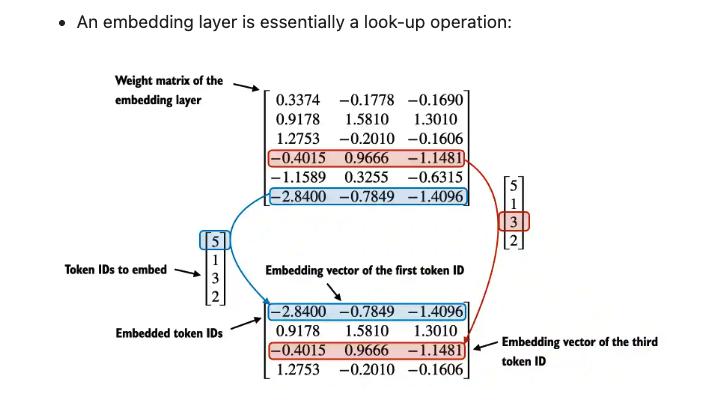

# Encoding word positions
- problem with ONLY token embeddings - same token IDs return the same embeddings, regardless of their position in the text.
- example ; 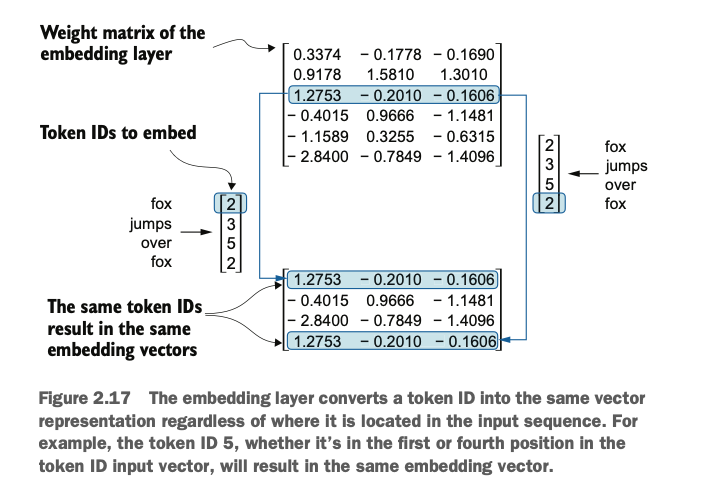
- why its important - Understanding the significance of word positions in embeddings helps capture the context and meaning of words in relation to each other.
- `In principle, the deterministic, position-independent embedding of the token ID is good for reproducibility purposes.`
- However, since the self-attention mechanism of LLMs itself is also position-agnostic, it is helpful to inject additional position information into the LLM.

### how to achieve the positional encoding?
- To achieve this, we can use two broad categories of position-aware embeddings
    - `relative position embeddings`
      - encodes the relative distance between tokens, allowing the model to understand how far apart words are from each other in a sequence.
      - example - if the word "not" appears before "happy," the model can learn that "not" negates the sentiment of "happy," regardless of their absolute positions in the text.
      - This is particularly useful for tasks where the relationship between words matters more than their exact positions, such as in sentiment analysis or question answering.
      - The Transformer-XL architecture introduced by Dai et al. in "Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context" uses relative positional encodings. They modify the attention mechanism to incorporate relative position information, allowing the model to capture dependencies between words based on their relative.
      - 
      
    - `absolute position embeddings`
       - encodes the exact position of each token in the sequence, providing a fixed reference point for the model to understand word order.
       - example - in the sentence "The cat sat on the mat," the absolute position embeddings would help the model recognize that "The" is the first word, "cat" is the second, and so on, preserving the original word order.
       - OpenAIs GPT models use absolute positional encodings. They add learned positional embeddings to the token embeddings, allowing the model to capture the order of words in a sequence effectively.
       - This is particularly useful for tasks where the order of words is crucial, such as in language translation or text generation.
       - The Transformer architecture introduced by Vaswani et al. in "Attention is All You Need" uses absolute positional encodings. They add sinusoidal position encodings to the token embeddings, allowing the model to capture the order of words in a sequence effectively.
       - example - BERT (Bidirectional Encoder Representations from Transformers) also employs absolute positional embeddings. BERT adds learned positional embeddings to the token embeddings, enabling the model to understand the position of each token in the input sequence.

### positinal encoding implementation


In [ ]:
vocab_size = 50257 # BPE tokenizer we implemented earlier, which has a vocabulary size of 50,257
output_dim = 256 # embedding dimension - how many numbers represent a token

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim) # token embedding layer for LLMs

max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

print("Token IDs:\n", inputs) # inputs is a batch of token IDs with shape (batch_size, max_length)
print("\nInputs shape:\n", inputs.shape) # should be (8, 4) for batch_size=8 and max_length=4

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [98]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
# print(token_embeddings) # matrix is of shape (8, 4, 256) - 8 sequences in the batch, each of length 4, and each token represented by a vector of size 256


torch.Size([8, 4, 256])


#### GPT-2 uses absolute position embeddings, so we just create another embedding layer

In [100]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)  # difference from token embedding layer is that here the input is position IDs (0, 1, 2, ..., max_length-1) instead of token IDs. 

# uncomment & execute the following line to see how the embedding layer weights look like
print(pos_embedding_layer.weight)


pos_embeddings = pos_embedding_layer(torch.arange(max_length))  # difference from token embedding layer is that here the input is position IDs (0, 1, 2, ..., max_length-1) instead of token IDs. 
print(pos_embeddings.shape)  # should be (4, 256) for max_length=4

# uncomment & execute the following line to see how the embeddings look like
print(pos_embeddings)

Parameter containing:
tensor([[-0.6451, -0.6397,  0.3619,  ...,  0.4454,  0.4887,  0.5341],
        [ 0.0851, -0.3358, -0.3749,  ...,  1.2503,  0.2494,  1.2698],
        [ 1.4413,  0.1969,  0.0874,  ..., -0.6001, -0.0722,  0.4005],
        [-1.5235,  0.8094,  0.4816,  ..., -0.2414, -1.5252,  1.0934]],
       requires_grad=True)
torch.Size([4, 256])
tensor([[-0.6451, -0.6397,  0.3619,  ...,  0.4454,  0.4887,  0.5341],
        [ 0.0851, -0.3358, -0.3749,  ...,  1.2503,  0.2494,  1.2698],
        [ 1.4413,  0.1969,  0.0874,  ..., -0.6001, -0.0722,  0.4005],
        [-1.5235,  0.8094,  0.4816,  ..., -0.2414, -1.5252,  1.0934]],
       grad_fn=<EmbeddingBackward0>)


## IMP - To create the input embeddings used in an LLM, we simply add the token and the positional embeddings:

In [102]:
input_embeddings = token_embeddings + pos_embeddings # 
print(input_embeddings.shape)  # should be (8, 4, 256) for the input shape because we are adding (8, 4, 256) + (4, 256) - broadcasting in action

# uncomment & execute the following line to see how the embeddings look like
print(input_embeddings)  # final input embeddings after adding token and position embeddings

torch.Size([8, 4, 256])
tensor([[[-0.7803,  0.4931,  0.6664,  ..., -0.2982,  0.2054, -1.1181],
         [-0.1678,  0.6988, -0.6209,  ...,  1.9709,  0.6565,  0.5605],
         [-0.0300, -1.1536,  0.5860,  ..., -1.3943, -0.8586,  1.5175],
         [-0.2712,  0.9240, -0.0620,  ...,  0.3604, -0.2292,  0.4807]],

        [[ 1.3713, -1.7873, -0.0424,  ...,  0.1224,  0.7864,  0.5912],
         [-0.5420,  1.0623, -0.6529,  ...,  1.1789,  0.7068,  2.2713],
         [-0.5060,  1.2555, -1.3363,  ..., -1.1436, -0.9601, -0.0268],
         [-0.4201,  1.8450, -1.0690,  ...,  1.9112, -1.5502,  0.7546]],

        [[-0.4767, -0.4201,  1.8582,  ...,  1.4673,  1.2550,  3.0997],
         [-0.2134, -0.4200, -0.8839,  ..., -0.3948,  0.8995,  2.0208],
         [ 1.8851, -1.4240,  0.0992,  ..., -0.8879, -1.2938,  0.9217],
         [-2.7090,  1.2139, -0.1789,  ...,  1.4028, -0.1912,  1.1062]],

        ...,

        [[-2.7588, -1.9927,  1.5728,  ...,  1.2705, -0.5514,  1.1914],
         [-0.5071, -0.4319,  0.07

# Final input embeddings pipeline

- 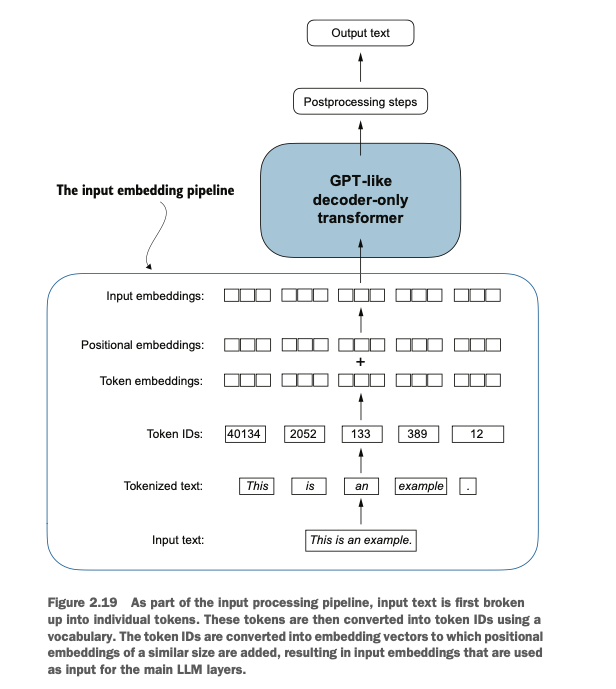